<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/docs/tutorials/kb_building_atlas/R/kb_analysis_0_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of single-cell RNA-seq data: building and annotating an atlas
This R notebook pre-processes the [pbmc_1k v3 dataset](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_1k_v3) from 10X Genomics with kallisto and bustools using `kb`, and then performs an analysis of the cell types and their marker genes.

The notebook was written by A. Sina Booeshaghi, Lambda Lu and Lior Pachter and is based on three noteboks:
- The kallisto | bustools [Introduction to single-cell RNA-seq I](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_1_minute_intro.ipynb#scrollTo=wtwMjIjjCMcD) notebook.
- The kallisto | bustools [Introduction to single-cell RNA-seq II](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_standard.ipynb#scrollTo=ijU_u6uj3Sio) notebook.
- The Seurat [Guided Clustering Tutorial](https://satijalab.org/seurat/v3.1/pbmc3k_tutorial.html).

If you use the methods in this notebook for your analysis please cite the following publications which describe the tools used in the notebook:

* Melsted, P., Booeshaghi, A.S. et al. Modular and efficient pre-processing of single-cell RNA-seq. bioRxiv (2019). doi:10.1101/673285
* Stuart, Butler et al. Comprehensive Integration of Single-cell Data. Cell (2019). doi:10.1016/j.cell.2019.05.031

A Python notebook implementing the same analysis is available [here](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_analysis_0_python.ipynb#scrollTo=3kZG9UyUPE_B). See the [kallistobus.tools tutorials](https://www.kallistobus.tools/tutorials) site for additional notebooks demonstrating other analyses.


## Setup

In [1]:
# This is used to time the running of the notebook
start_time <- Sys.time()

### Install R packages
A large fraction of the running time of this notebook is in installing the Seurat R package, since it has lots of dependencies and many of them use Rcpp which results in the need to compile lots of C++ code. Compilation is required because CRAN does not distribute binaries for Linux, which is the operating system here.

In [2]:
system.time({
  install.packages("Seurat", Ncpus = 2)
})

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘sass’, ‘jquerylib’, ‘sitmo’, ‘globals’, ‘listenv’, ‘parallelly’, ‘plyr’, ‘zoo’, ‘htmlwidgets’, ‘lazyeval’, ‘crosstalk’, ‘promises’, ‘gplots’, ‘reshape2’, ‘gridExtra’, ‘RcppArmadillo’, ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘later’, ‘bslib’, ‘spatstat.data’, ‘spatstat.utils’, ‘spatstat.sparse’, ‘abind’, ‘tensor’, ‘goftest’, ‘deldir’, ‘polyclip’, ‘FNN’, ‘RSpectra’, ‘dqrng’, ‘cowplot’, ‘fitdistrplus’, ‘future’, ‘future.apply’, ‘ggrepel’, ‘ggridges’, ‘ica’, ‘igraph’, ‘irlba’, ‘leiden’, ‘lmtest’, ‘matrixStats’, ‘miniUI’, ‘patchwork’, ‘pbapply’, ‘plotly’, ‘png’, ‘RANN’, ‘RcppAnnoy’, ‘reticulate’, ‘ROCR’, ‘Rtsne’, ‘scattermore’, ‘sctransform’, ‘SeuratObject’, ‘shiny’, ‘spatstat.core’, ‘spatstat.geom’, ‘uwot’, ‘RcppEigen’, ‘RcppProgress’




    user   system  elapsed 
1667.646  158.004 1005.739 

The package installation took 20 minutes (elapsed) which is 40% of the running time of the entire notebook. The user time is nearly twice the elapsed time here because 2 cores were used to install all those packages.

### Install kb-python

In [3]:
# Install kb (includes installing kallisto and bustools)
system("pip3 install kb-python", intern=TRUE)

[1] "Collecting kb-python"                                                                                                                                                                                                                                               
  [2] "  Downloading https://files.pythonhosted.org/packages/a9/99/4ff26e6e51d586f3d34550f3f50f681facf43124a1a83c562e3fb9dd51e9/kb_python-0.26.3.tar.gz (7.4MB)"                                                                                                           
  [3] "Collecting anndata>=0.6.22.post1"                                                                                                                                                                                                                                   
  [4] "  Downloading https://files.pythonhosted.org/packages/b8/ac/92f7a3687270dabd13c4bf8ec9ec4e9577df75311743982d63a644cff780/anndata-0.7.6-py3-none-any.whl (127kB)"                                                                                                    
  [5] "Requirement already satisfied: h5py>=2.10.0 in /usr/local/lib/python3.7/dist-packages (from kb-python) (3.1.0)"                                                                                                                                                     
  [6] "Requirement already satisfied: Jinja2>2.10.1 in /usr/local/lib/python3.7/dist-packages (from kb-python) (2.11.3)"                                                                                                                                                   
  [7] "Collecting loompy>=3.0.6"                                                                                                                                                                                                                                           
  [8] "  Downloading https://files.pythonhosted.org/packages/36/52/74ed37ae5988522fbf87b856c67c4f80700e6452410b4cd80498c5f416f9/loompy-3.0.6.tar.gz (41kB)"                                                                                                                
  [9] "Requirement already satisfied: nbconvert>=5.6.0 in /usr/local/lib/python3.7/dist-packages (from kb-python) (5.6.1)"                                                                                                                                                 
 [10] "Requirement already satisfied: nbformat>=4.4.0 in /usr/local/lib/python3.7/dist-packages (from kb-python) (5.1.3)"                                                                                                                                                  
 [11] "Collecting ngs-tools>=1.3.0"                                                                                                                                                                                                                                        
 [12] "  Downloading https://files.pythonhosted.org/packages/67/79/91cfb2bf05a4174358fe2f5e40018ac8d7bd25bdec624c8db7a1754be684/ngs-tools-1.5.2.tar.gz (51.7MB)"                                                                                                           
 [13] "Requirement already satisfied: numpy>=1.17.2 in /usr/local/lib/python3.7/dist-packages (from kb-python) (1.19.5)"                                                                                                                                                   
 [14] "Requirement already satisfied: pandas>=1.0.0 in /usr/local/lib/python3.7/dist-packages (from kb-python) (1.1.5)"                                                                                                                                                    
 [15] "Collecting plotly>=4.5.0"                                                                                                                                                                                                                          

### Download the data

In [4]:
# Download the data from the 10x website
system("wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v3/pbmc_1k_v3_fastqs.tar", intern=TRUE)
system("tar -xvf pbmc_1k_v3_fastqs.tar", intern=TRUE)

character(0)

[1] "pbmc_1k_v3_fastqs/"                                  
[2] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz"
[3] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_I1_001.fastq.gz"
[4] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz"
[5] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz"
[6] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz"
[7] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_I1_001.fastq.gz"

### Download an index

In [5]:
system("kb ref -d human -i index.idx -g t2g.txt -f1 transcriptome.fasta",intern=TRUE)

character(0)

## Pseudoalignment and counting

### Run kallisto and bustools

In [6]:
system("kb count -i index.idx -g t2g.txt -x 10xv3 -o output --filter bustools -t 2 pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz",intern=TRUE)

character(0)

## Basic QC

In [7]:
library(Seurat)
library(Matrix)
library(tidyverse)
library(patchwork)
theme_set(theme_bw())

Attaching SeuratObject

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()



In [8]:
list.files(".", recursive = TRUE)

[1] "index.idx"                                           
 [2] "output/10x_version3_whitelist.txt"                   
 [3] "output/counts_filtered/cells_x_genes.barcodes.txt"   
 [4] "output/counts_filtered/cells_x_genes.genes.txt"      
 [5] "output/counts_filtered/cells_x_genes.mtx"            
 [6] "output/counts_unfiltered/cells_x_genes.barcodes.txt" 
 [7] "output/counts_unfiltered/cells_x_genes.genes.txt"    
 [8] "output/counts_unfiltered/cells_x_genes.mtx"          
 [9] "output/filter_barcodes.txt"                          
[10] "output/inspect.json"                                 
[11] "output/kb_info.json"                                 
[12] "output/matrix.ec"                                    
[13] "output/output.bus"                                   
[14] "output/output.filtered.bus"                          
[15] "output/output.unfiltered.bus"                        
[16] "output/run_info.json"                                
[17] "output/transcripts.txt"                              
[18] "pbmc_1k_v3_fastqs.tar"                               
[19] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_I1_001.fastq.gz"
[20] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz"
[21] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz"
[22] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_I1_001.fastq.gz"
[23] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz"
[24] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz"
[25] "sample_data/anscombe.json"                           
[26] "sample_data/california_housing_test.csv"             
[27] "sample_data/california_housing_train.csv"            
[28] "sample_data/mnist_test.csv"                          
[29] "sample_data/mnist_train_small.csv"                   
[30] "sample_data/README.md"                               
[31] "t2g.txt"

In [9]:
# Slightly modified from BUSpaRse, just to avoid installing a few dependencies not used here
read_count_output <- function(dir, name) {
  dir <- normalizePath(dir, mustWork = TRUE)
  m <- readMM(paste0(dir, "/", name, ".mtx"))
  m <- Matrix::t(m)
  m <- as(m, "dgCMatrix")
  # The matrix read has cells in rows
  ge <- ".genes.txt"
  genes <- readLines(file(paste0(dir, "/", name, ge)))
  barcodes <- readLines(file(paste0(dir, "/", name, ".barcodes.txt")))
  colnames(m) <- barcodes
  rownames(m) <- genes
  return(m)
}

In [10]:
res_mat <- read_count_output("./output/counts_unfiltered", name = "cells_x_genes")

In [11]:
dim(res_mat)

[1]  60623 259615

### Test for library saturation

In [12]:
tot_counts <- colSums(res_mat)
lib_sat <- tibble(nCount = tot_counts,
                  nGene = colSums(res_mat > 0))

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


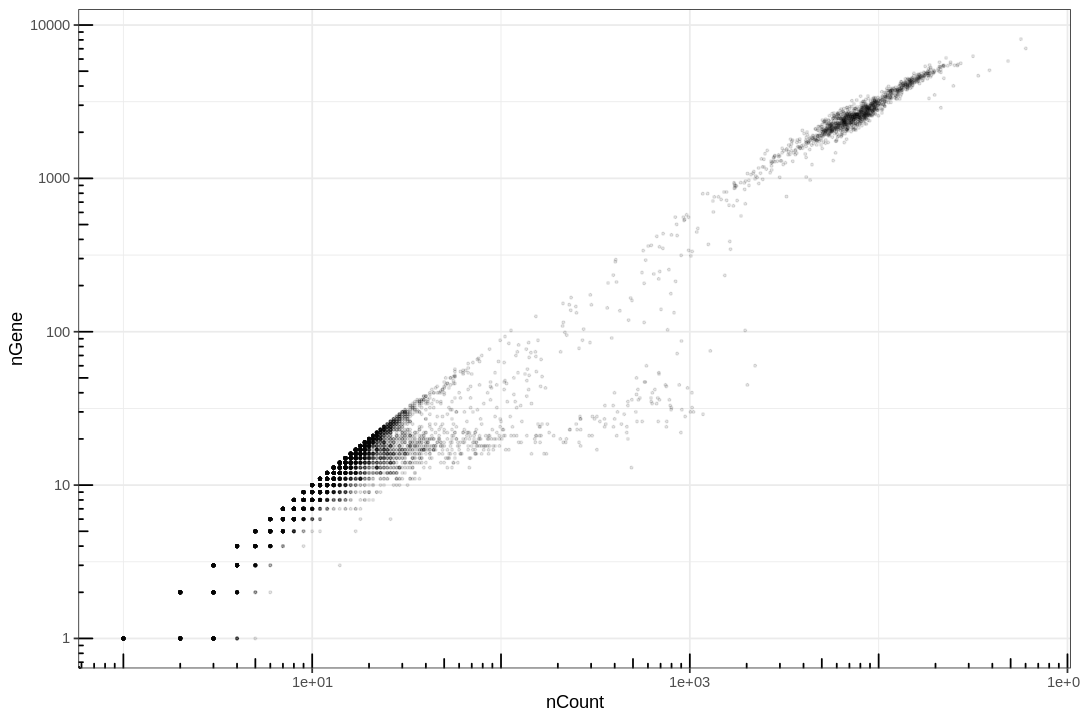

In [13]:
options(repr.plot.width=9, repr.plot.height=6)
ggplot(lib_sat, aes(nCount, nGene)) +
  geom_point(alpha = 0.1, size = 0.5) +
  scale_x_log10() + scale_y_log10() + annotation_logticks()

This plot is very misleading, as even the small alpha can't accurately show how many points are stacked at one location.

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 19583 rows containing non-finite values (stat_bin2d).”


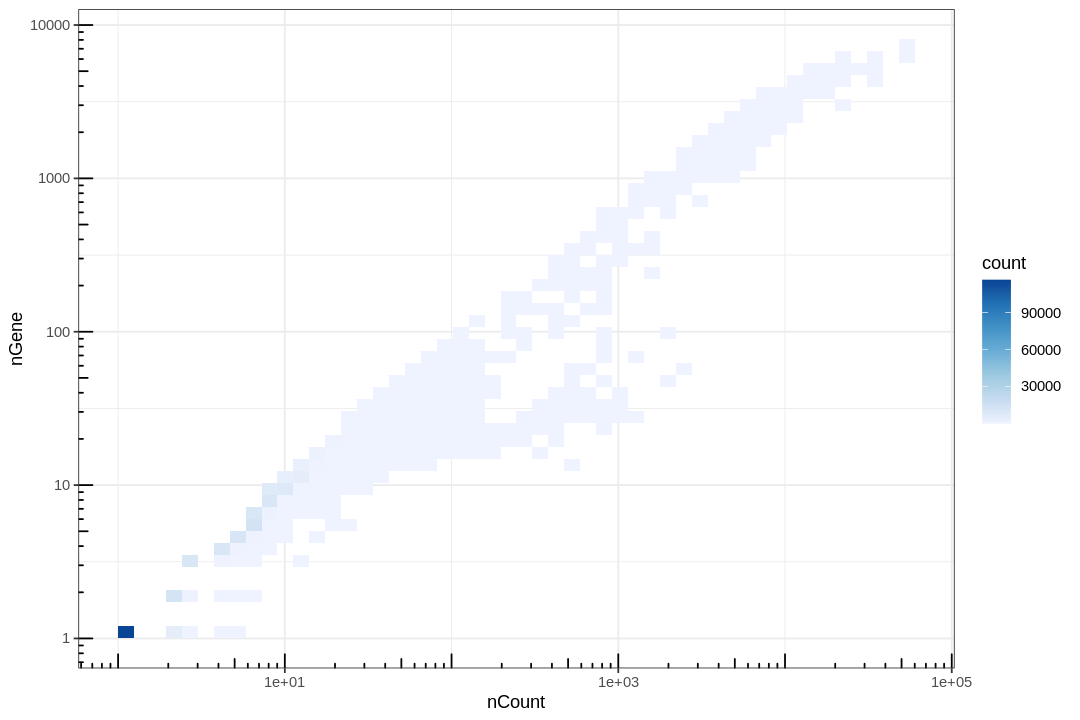

In [14]:
ggplot(lib_sat, aes(nCount, nGene)) +
  geom_bin2d(bins = 50) +
  scale_fill_distiller(palette = "Blues", direction = 1) +
  scale_x_log10() + scale_y_log10() + annotation_logticks()

Lots of points are piled at around 1 gene and 1 count, and those with 0 gene or count were removed for introducing -Inf in log transform. These correspond to empty or near empty droplets.

### Examine the knee plot

The "knee plot" was introduced in the Drop-seq paper: 
- Macosko et al., [Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets](https://www.cell.com/fulltext/S0092-8674(15)00549-8), 2015. DOI:10.1016/j.cell.2015.05.002

In this plot cells are ordered by the number of UMI counts associated to them (shown on the *x*-axis), and the fraction of droplets with at least that number of cells is shown on the *y*-axis:

In [15]:
summary(tot_counts)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     1.00     1.00    43.64     6.00 60120.00 

In [16]:
#' @rdname knee_plot
#' @param mat Gene count matrix, a dgCMatrix.
#' @return `get_knee_df` returns a tibble with two columns: \code{total} for 
#' total UMI counts for each barcode, and \code{rank} for rank of the total 
#' counts, with number 1 for the barcode with the most counts.
#' @export
#' @importFrom dplyr row_number desc arrange
#' @importFrom Matrix colSums
get_knee_df <- function(mat) {
  total <- rank <- NULL
  tibble(total = Matrix::colSums(mat),
         rank = row_number(desc(total))) %>%
    distinct() %>%
    dplyr::filter(total > 0) %>% 
    arrange(rank)
}

#' @rdname knee_plot
#' @param df The data frame from \code{\link{get_knee_df}}.
#' @param lower Minimum total UMI counts for barcode for it to be considered
#' when calculating the inflection point; this helps to avoid the noisy part of
#' the curve for barcodes with very few counts.
#' @return `get_inflection` returns a \code{numeric(1)} for the total UMI count 
#' at the inflection point.
#' @note Code in part adapted from \code{barcodeRanks} from \code{DropetUtils}.
#' @export
#' @importFrom dplyr transmute
#' 
get_inflection <- function(df, lower = 100) {
  log_total <- log_rank <- total <-  NULL
  df_fit <- df %>% 
    dplyr::filter(total > lower) %>% 
    transmute(log_total = log10(total),
              log_rank = log10(rank))
  d1n <- diff(df_fit$log_total)/diff(df_fit$log_rank)
  right.edge <- which.min(d1n)
  10^(df_fit$log_total[right.edge])
}

#' Plot the transposed knee plot and inflection point
#' 
#' Plot a transposed knee plot, showing the inflection point and
#' the number of remaining cells after inflection point filtering. It's
#' transposed since it's more generalizable to multi-modal data. Taken from the 
#' BUSpaRse package.
#' 
#' @param df The data frame from \code{\link{get_knee_df}}.
#' @param inflection Output of \code{\link{get_inflection}}.
#' @return `knee_plot` returns a \code{ggplot2} object.
#' @export
#' @importFrom ggplot2 ggplot aes geom_path geom_vline geom_hline 
#' scale_x_log10 scale_y_log10 labs annotation_logticks geom_text
knee_plot <- function(df, inflection) {
  total <- rank_cutoff <- NULL
  annot <- tibble(inflection = inflection,
                  rank_cutoff = max(df$rank[df$total > inflection]))
  ggplot(df, aes(total, rank)) +
    geom_path() +
    geom_vline(aes(xintercept = inflection), data = annot, linetype = 2, 
               color = "gray40") +
    geom_hline(aes(yintercept = rank_cutoff), data = annot, linetype = 2, 
               color = "gray40") +
    geom_text(aes(inflection, rank_cutoff, 
                  label = paste(rank_cutoff, "'cells'")),
              data = annot, vjust = 1) +
    scale_x_log10() +
    scale_y_log10() +
    labs(y = "Rank", x = "Total UMIs") +
    annotation_logticks()
}

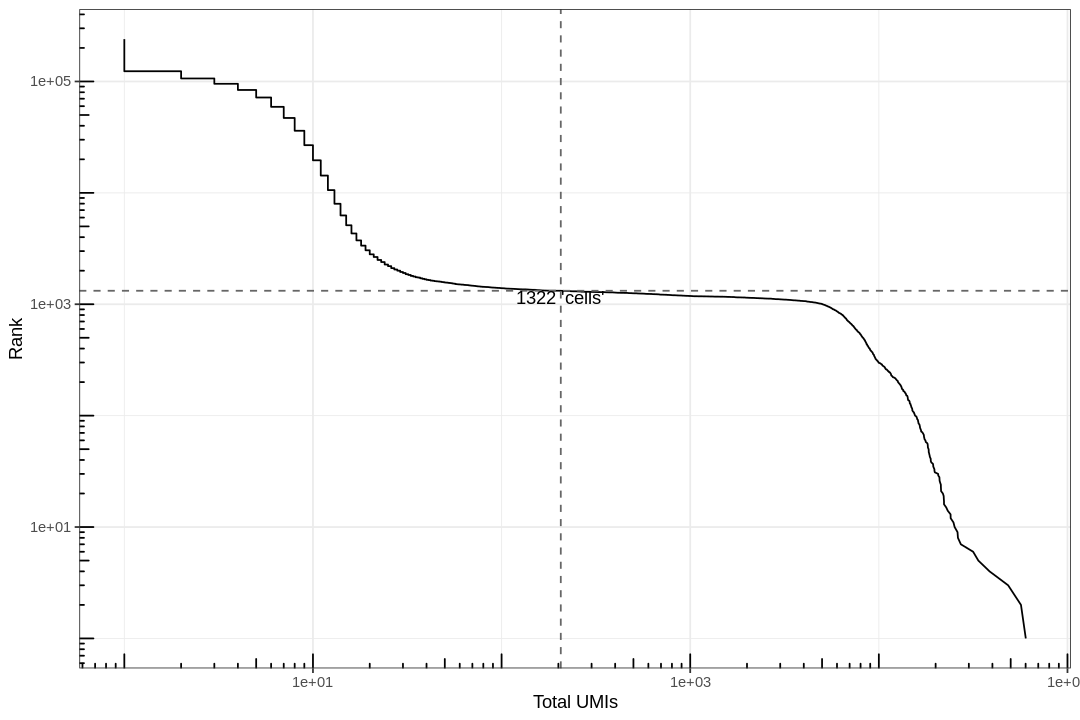

In [17]:
options(repr.plot.width=9, repr.plot.height=6)
knee_df <- get_knee_df(res_mat)
inflection <- get_inflection(knee_df)
knee_plot(knee_df, inflection)

## Analysis
We begin by asking for genes with the highest proportions in droplets (prior to filtering out empty droplets).

In [18]:
tr2g <- read_tsv("t2g.txt", col_names = c("transcript", "gene", "gene_name"))
tr2g <- distinct(tr2g[, c("gene", "gene_name")])


── Column specification ────────────────────────────────────────────────────────
cols(
  transcript = col_character(),
  gene = col_character(),
  gene_name = col_character()
)




In [19]:
plot_pct_genes <- function(mat, tr2g, top_n = 20, symbol = "ensembl") {
  pct_tx <- rowSums(mat)
  gs <- rownames(mat)[order(-pct_tx)]
  df <- as.data.frame(t(mat[gs[1:20],]))
  df <- df %>%
    mutate_all(function(x) x/colSums(mat)) %>%
    pivot_longer(everything(), names_to = "gene")
  if (symbol == "ensembl") {
    df <- left_join(df, tr2g, by = "gene")
  } else {
    df <- rename(df, gene_name = gene)
  }
    df %>%
    mutate(gene = fct_reorder(gene_name, value, .fun = median)) %>%
    ggplot(aes(gene, value)) +
    geom_boxplot() +
    labs(x = "", y = "Proportion of total counts") +
    coord_flip()
}

Warning message:
“Removed 391660 rows containing non-finite values (stat_boxplot).”


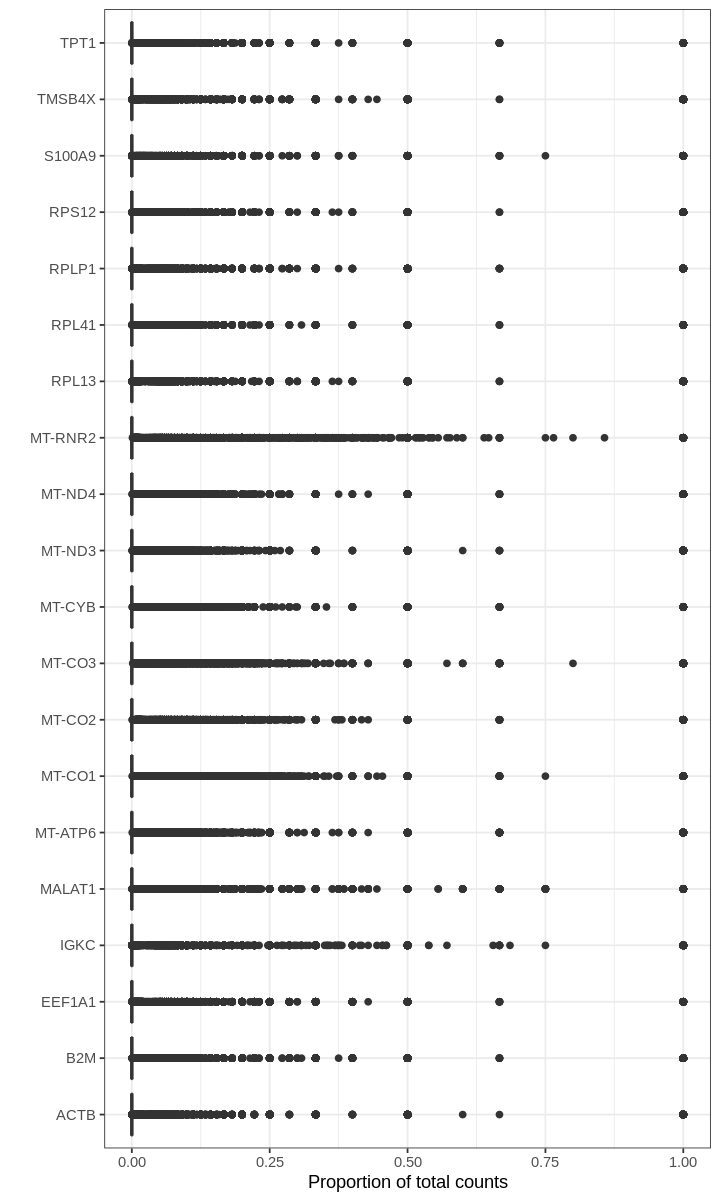

In [20]:
options(repr.plot.width=6, repr.plot.height=10)
plot_pct_genes(res_mat, tr2g)

For many barcodes, the top genes by proportion of all counts are ribosomal or mitochondrial genes. Also, the proportions plotted above seem to have some discrete values; this effect is a result of computing fractions with small denominator, which happens when droplets produce very few UMI counts.

### Filter

In [21]:
res_mat <- res_mat[, tot_counts > inflection]
res_mat <- res_mat[Matrix::rowSums(res_mat) > 0,]
dim(res_mat)

[1] 31861  1322

In [22]:
# Convert from Ensembl gene ID to gene symbol
rownames(res_mat) <- tr2g$gene_name[match(rownames(res_mat), tr2g$gene)]

In [23]:
(pbmc <- CreateSeuratObject(counts = res_mat, project = "pbmc1k", min.cells = 3, min.features = 200))

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
25966 features across 1208 samples within 1 assay 
Active assay: RNA (25966 features, 0 variable features)

The steps below constitute a standard analysis worklow for single-cell RNA-seq data. 

In [24]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

The number of unique genes and total molecules are automatically calculated when running the `CreateSeuratObject` command.
The associated data is stored in the object metadata.


In [25]:
# Show QC metrics for the first 5 cells
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACCCAAGGAGAGTA,pbmc1k,9289,3198,11.271396
AAACGCTTCAGCCCAG,pbmc1k,6483,2513,8.252352
AAAGAACAGACGACTG,pbmc1k,5011,2082,6.166434
AAAGAACCAATGGCAG,pbmc1k,3264,1555,6.893382
AAAGAACGTCTGCAAT,pbmc1k,7488,2508,6.610577


Next, we visualize some QC metrics and use the results to set filtering criteria.

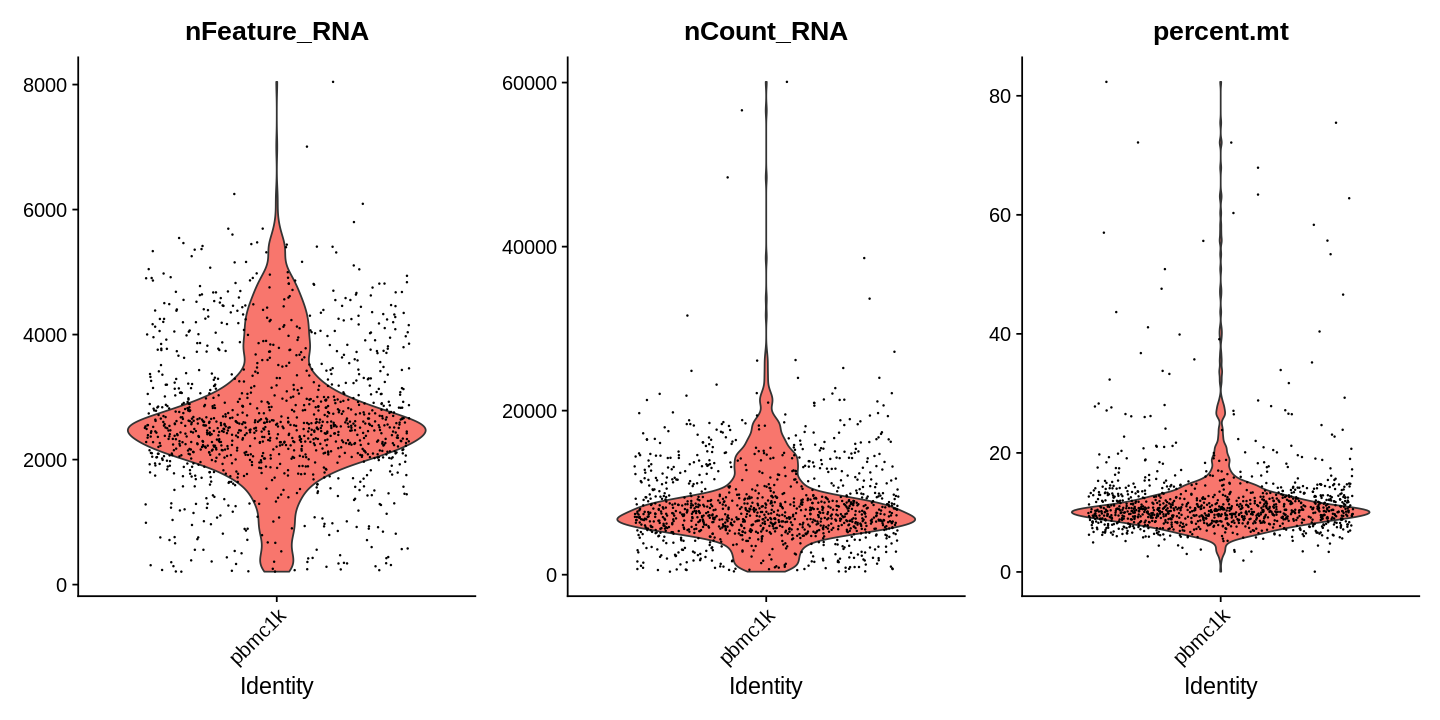

In [26]:
# Visualize QC metrics as a violin plot
options(repr.plot.width=12, repr.plot.height=6)
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

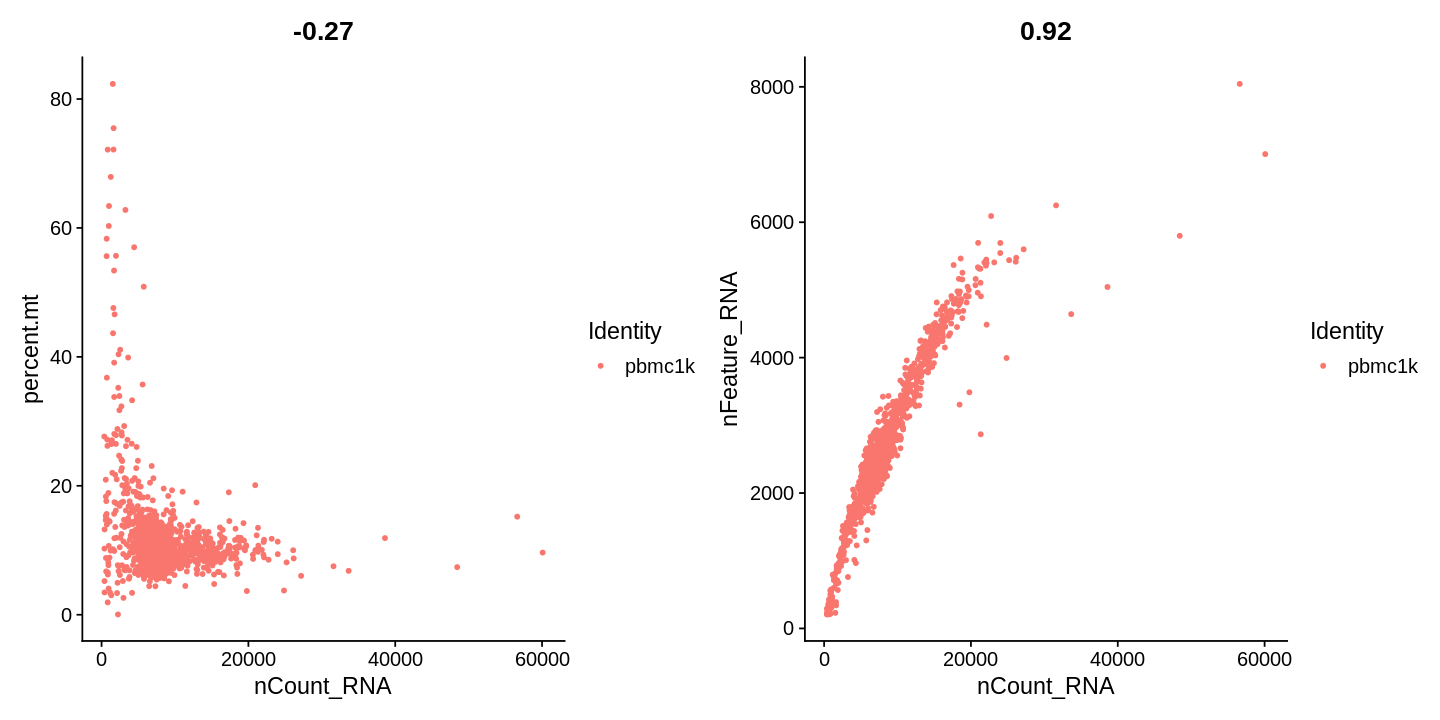

In [27]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.
plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [28]:
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 6500 & percent.mt < 20)

### Normalize

After removing unwanted cells from the dataset, the next step is to normalize the data. A standard choice is `LogNormalize` which normalizes the UMI counts for each cell by the total counts, multiplies this by a scale factor (10,000 by default), and finally log-transforms the result. 

We recommend the preprint 
- Breda, J., Zavolan, M. and van Nimwegen, E. Bayesian inference of the gene expression states of single cells from scRNA-seq data. bioRxiv (2019). doi.org/10.1101/2019.12.28.889956 

for a thorough discussion of normalization.

In [29]:
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

For clarity, in this previous line of code (and in future commands), we provide the default values for certain parameters in the function call. However, this isn’t required and the same behavior can be achieved with:

In [30]:
# pbmc <- NormalizeData(pbmc)

### Highly expressed genes


To identify a subset of genes that exhibit high cell-to-cell variation in the dataset we apply a procedure implemented in the `FindVariableFeatures` function. By default, it returns 2,000 genes per dataset. These will be used in downstream analysis.

Seurat documentation describes the method used to find highly variable genes here as such:

> First, fits a line to the relationship of log(variance) and log(mean) using local polynomial regression (loess). Then standardizes the feature values using the observed mean and expected variance (given by the fitted line). Feature variance is then calculated on the standardized values after clipping to a maximum (see clip.max parameter).

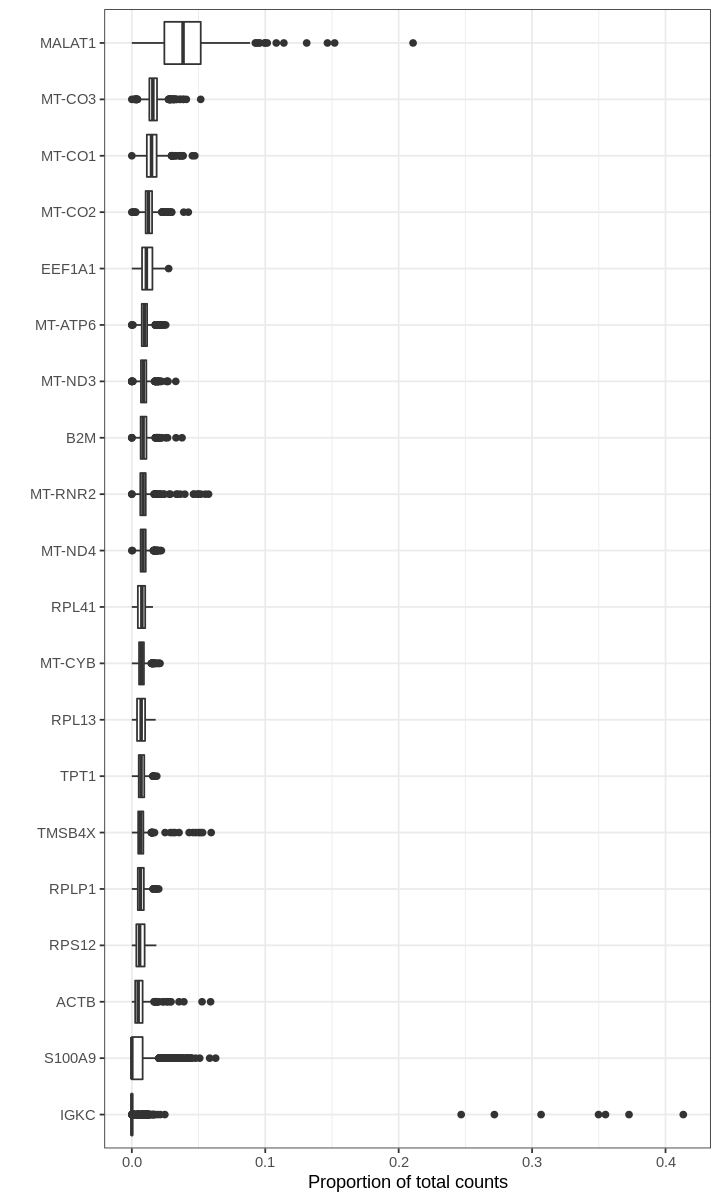

In [31]:
options(repr.plot.width=6, repr.plot.height=10)
plot_pct_genes(GetAssayData(pbmc, slot = "counts"), tr2g, symbol = "symbol")

When using repel, set xnudge and ynudge to 0 for optimal results



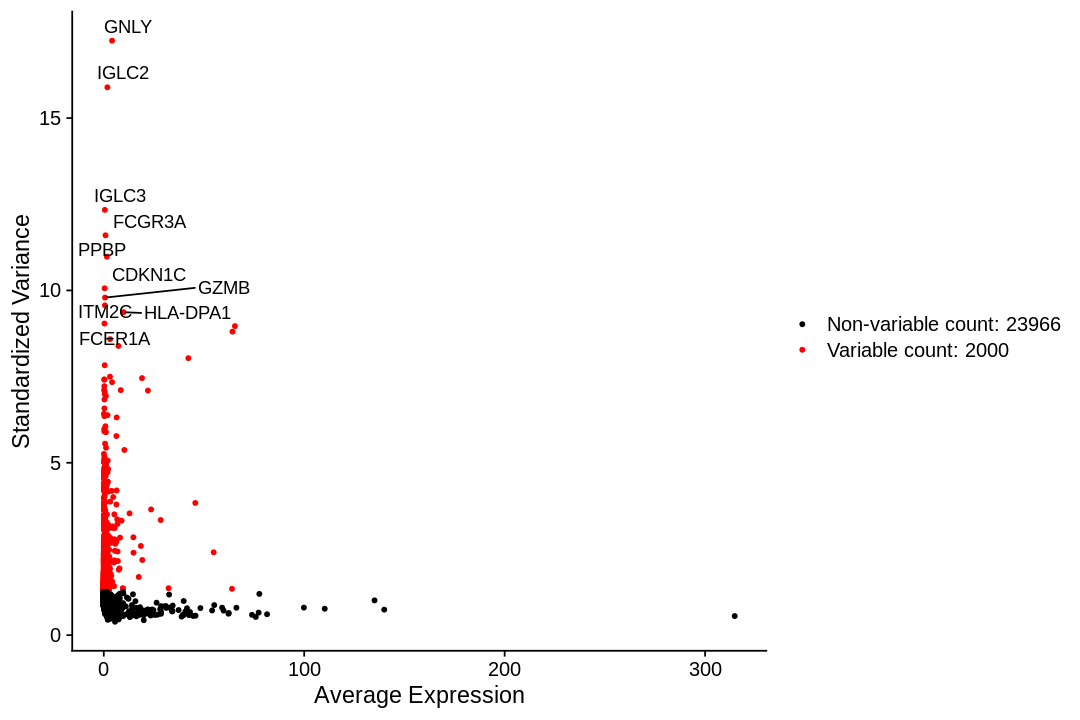

In [32]:
options(repr.plot.width=9, repr.plot.height=6)
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc, log = FALSE)
LabelPoints(plot = plot1, points = top10, repel = TRUE)

### Scaling the data
Next, we apply a linear transformation (‘scaling’) that is a standard pre-processing step prior to dimensional reduction techniques like PCA. The ScaleData function shifts the expression of each gene, so that the mean expression across cells is 0 and the variance across cells is 1
This step gives equal weight to genes in downstream analyses, so that highly-expressed genes do not dominate.

In [33]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



We apply this only to the genes identified as highly variable:

In [34]:
# pbmc <- ScaleData(pbmc)

The scaling does not affect PCA or clustering results. However, Seurat heatmaps (produced as shown below with DoHeatmap) require genes in the heatmap to be scaled so that highly-expressed genes don’t dominate. To make sure we don’t leave any genes out of the heatmap later, we are scaling all genes in this tutorial.



In Seurat v2 we also use the ScaleData function to remove unwanted sources of variation from a single-cell dataset. For example, we could ‘regress out’ heterogeneity associated with (for example) cell cycle stage, or mitochondrial contamination. These features are still supported in ScaleData in Seurat v3, i.e.:

In [35]:
# pbmc <- ScaleData(pbmc, vars.to.regress = "percent.mt")

### Principal component analysis

Next we perform PCA on the scaled data. By default, only the previously determined variable features are used as input.

In [36]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  S100A9, FCN1, MNDA, FGL2, S100A8, CTSS, CST3, SERPINA1, PSAP, NCF2 
	   LYZ, AIF1, TYMP, VCAN, KLF4, GRN, CSTA, MPEG1, CPVL, CLEC7A 
	   LST1, MS4A6A, CD14, LGALS1, S100A12, TYROBP, TNFAIP2, FCER1G, CD36, CSF3R 
Negative:  LTB, TRAC, TRBC2, CD3D, IL32, BCL11B, CD3G, IL7R, TCF7, CD69 
	   ISG20, CD247, CD27, SPOCK2, ARL4C, CD7, CD2, GZMM, TRBC1, CD6 
	   PRKCQ-AS1, NOSIP, AC058791.1, RORA, CTSW, CCR7, AQP3, ITM2A, PEBP1, SAMD3 
PC_ 2 
Positive:  CD79A, MS4A1, IGHM, BANK1, BCL11A, LINC00926, CD79B, TNFRSF13C, IGHD, CD74 
	   HLA-DQB1, CD22, HLA-DQA1, HLA-DRB1, HLA-DRA, HLA-DPA1, HLA-DPB1, TCL1A, FCER2, AFF3 
	   PAX5, IGKC, VPREB3, SPIB, MEF2C, RALGPS2, HVCN1, FCRL1, HLA-DOB, HLA-DMA 
Negative:  IL32, CD247, GZMM, CD7, CTSW, CD3D, GZMA, NKG7, S100A4, TRAC 
	   ANXA1, BCL11B, PRF1, CST7, KLRB1, CD3G, IL7R, ARL4C, SAMD3, CD2 
	   TRBC1, CCL5, KLRG1, A2M, MT2A, RORA, ITGB2, GNLY, TCF7, MATK 
PC_ 3 
Positive:  CAVIN2, GP9, PF4, GNG11, PPBP, CD9, TREML1, CMTM5, TUBB1, SPARC 

Seurat provides several useful ways of visualizing both cells and features that define the PCA, including VizDimReduction, DimPlot, and DimHeatmap



In [37]:
# Examine and visualize PCA results a few different ways
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  S100A9, FCN1, MNDA, FGL2, S100A8 
Negative:  LTB, TRAC, TRBC2, CD3D, IL32 
PC_ 2 
Positive:  CD79A, MS4A1, IGHM, BANK1, BCL11A 
Negative:  IL32, CD247, GZMM, CD7, CTSW 
PC_ 3 
Positive:  CAVIN2, GP9, PF4, GNG11, PPBP 
Negative:  CYBA, VIM, FOS, ITGB2, NEAT1 
PC_ 4 
Positive:  LEF1, TCF7, IL7R, MAL, CCR7 
Negative:  GZMB, GNLY, CLIC3, NKG7, KLRF1 
PC_ 5 
Positive:  LILRA4, SCT, PACSIN1, SMPD3, LRRC26 
Negative:  GNLY, FGFBP2, KLRF1, PRF1, NKG7 


Which genes are contributing the most to the first 2 PCs?

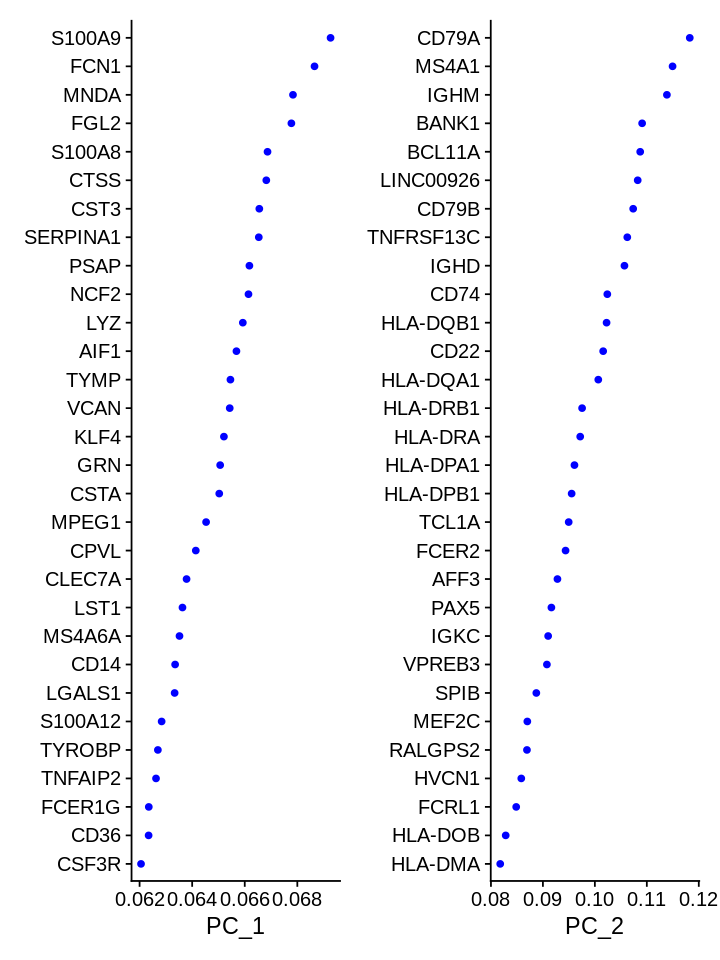

In [38]:
options(repr.plot.width=6, repr.plot.height=8)
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

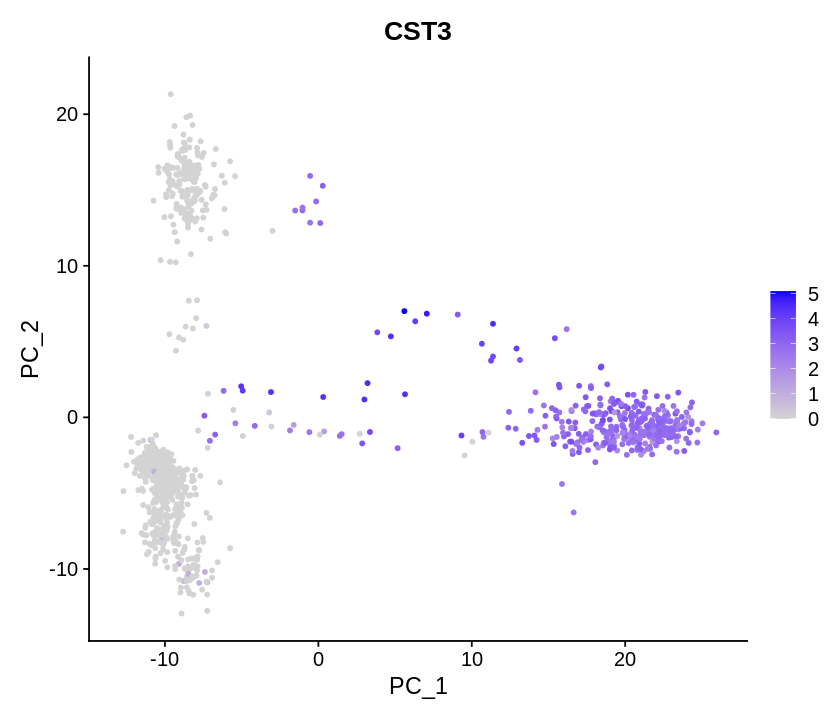

In [39]:
options(repr.plot.width=7, repr.plot.height=6)
FeaturePlot(pbmc, reduction = "pca", feature = "CST3")

### Determining dimensionality
To overcome the extensive technical noise in any single feature for scRNA-seq data, one can cluster cells based on their PCA projections, with each PC essentially representing a ‘metafeature’ that combines information across a correlated feature set.

A common heuristic method generates an ‘Elbow plot’: a ranking of principle components based on the percentage of variance explained by each one (ElbowPlot function). In this example, we can observe an ‘elbow’ around PC9-10, suggesting that the majority of true signal is captured in the first 10 PCs.

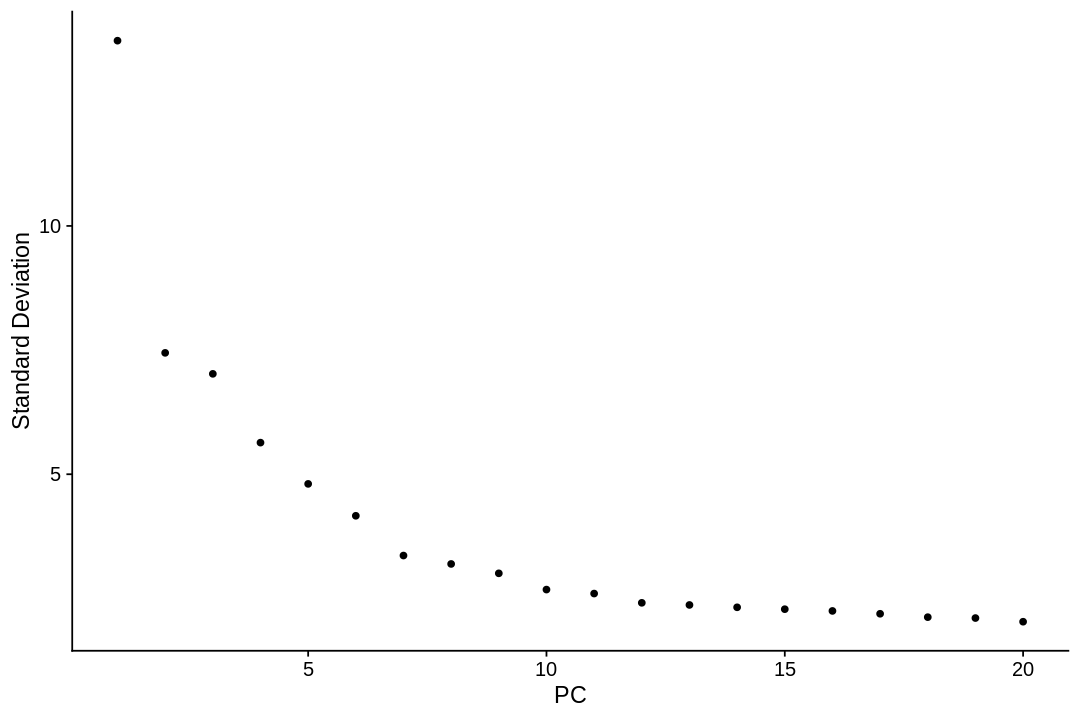

In [40]:
options(repr.plot.width=9, repr.plot.height=6)
ElbowPlot(pbmc)

### The neighborhood graph

We cluster cells using the Louvain algorithm (a default in Seurat), which iteratively group cells together, with the goal of optimizing the standard modularity function. The FindClusters function implements this procedure, and contains a resolution parameter that sets the ‘granularity’ of the downstream clustering, with increased values leading to a greater number of clusters. We find that setting this parameter between 0.4-1.2 typically returns good results for single-cell datasets of around 3K cells. Optimal resolution often increases for larger datasets. The clusters can be found using the Idents function.

In [41]:
pbmc <- FindNeighbors(pbmc, dims = 1:10, k.param = 20)
pbmc <- FindClusters(pbmc, resolution = 0.6)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1138
Number of edges: 35679

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8720
Number of communities: 9
Elapsed time: 0 seconds


In [42]:
# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

AAACCCAAGGAGAGTA AAACGCTTCAGCCCAG AAAGAACAGACGACTG AAAGAACCAATGGCAG 
               0                3                5                5 
AAAGAACGTCTGCAAT 
               1 
Levels: 0 1 2 3 4 5 6 7 8

### UMAP and t-SNE
tSNE and UMAP can be used to visualize and explore non-linear aspects of high-dimensional data. Here we apply these methods to the PC projection of the data (with same dimension as used for clustering).

[UMAP](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction) (UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction) is a manifold learning technique that can also be used to visualize cells. It was published in:

- McInnes, Leland, John Healy, and James Melville. "Umap: Uniform manifold approximation and projection for dimension reduction." arXiv preprint arXiv:1802.03426 (2018).

[t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) is a non-linear dimensionality reduction technique described in:

- Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of machine learning research 9.Nov (2008): 2579-2605.



In [43]:
pbmc <- RunUMAP(pbmc, dims = 1:10, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


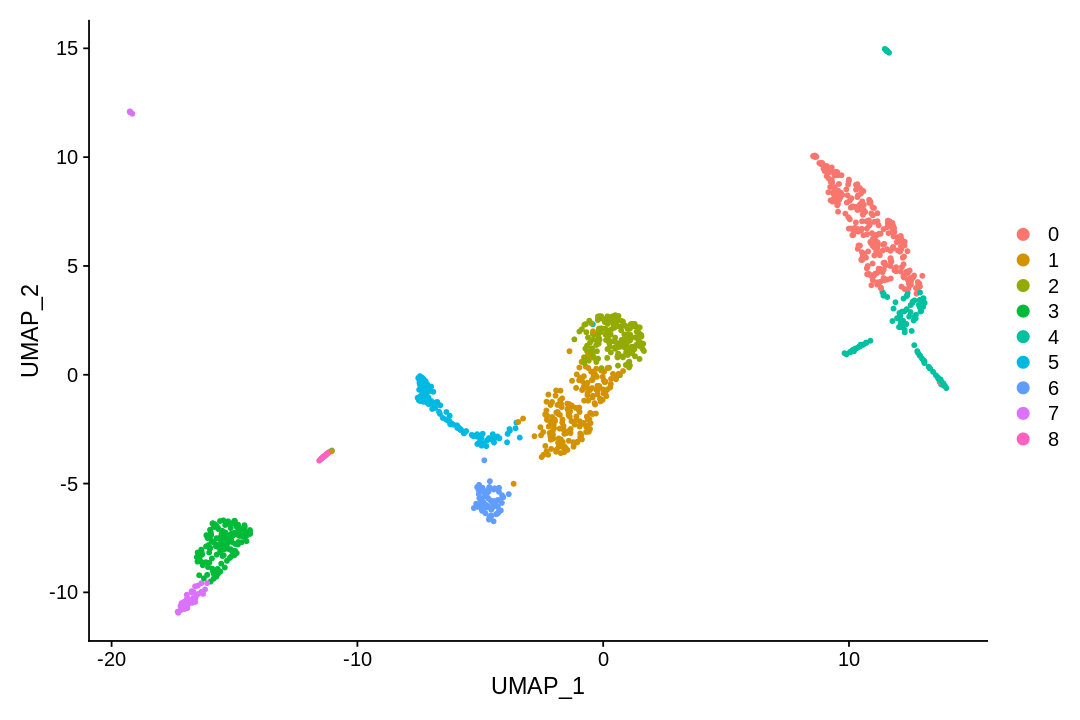

In [44]:
# note that you can set `label = TRUE` or use the LabelClusters function to help label
# individual clusters
DimPlot(pbmc, reduction = "umap")

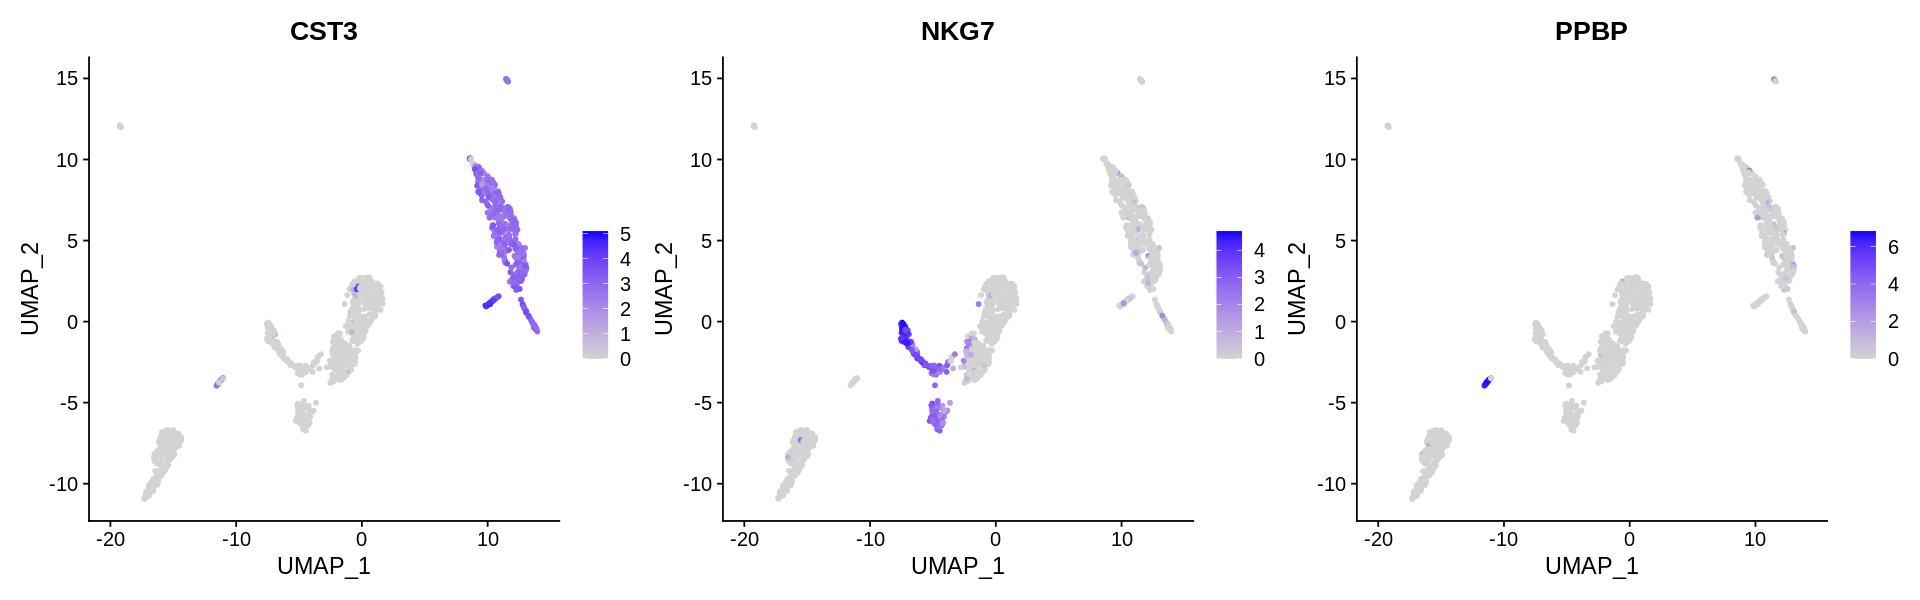

In [45]:
options(repr.plot.width=16, repr.plot.height=5)
FeaturePlot(pbmc, reduction = "umap", features = c("CST3", "NKG7", "PPBP"),
ncol = 3)

### Finding differentially expressed features (cluster biomarkers)
A key follow-up step to clustering cells is to find gene markers that are associated with them. We used Seurat's FindAllMarkers function which automates the process for all clusters.

The min.pct argument requires a feature to be detected at a minimum percentage in either of the two groups of cells, and the thresh.test argument requires a feature to be differentially expressed (on average) by some amount between the two groups. You can set both of these to 0, but with a dramatic increase in time - since this will test a large number of features that are unlikely to be highly discriminatory. As another option to speed up these computations, max.cells.per.ident can be set. This will downsample each identity class to have no more cells than whatever this is set to. While there is generally going to be a loss in power, the speed increases can be significiant and the most highly differentially expressed features will likely still rise to the top.

In [46]:
# Scanpy style gene rank plot
plot_gene_rank <- function(markers, n) {
  df_plot <- markers %>%
    group_by(cluster) %>%
    top_n(25, avg_log2FC) %>%
    mutate(rank = factor(row_number(desc(avg_log2FC))))
  ggplot(df_plot, aes(rank, avg_log2FC)) +
    geom_text(aes(label = gene), angle = -90, hjust = 1) +
    facet_wrap(~ cluster) +
    scale_y_continuous(expand = expansion(mult = c(0.05, 0.25)))
}

Several methods for differential expression are supported by Seurat. The default is Wilcoxon rank sum test.

In [47]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
pbmc.markers <- FindAllMarkers(pbmc, test.use = "wilcox", only.pos = TRUE, 
                               min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



In [48]:
head(pbmc.markers)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
S100A12,4.064804e-197,4.213263,0.978,0.076,1.055467e-192,0,S100A12
VCAN,3.352042e-189,3.484980,0.996,0.104,8.703913e-185,0,VCAN
S100A8,4.318649e-186,5.520490,1.000,0.143,1.121380e-181,0,S100A8
CD14,7.936720e-173,2.574749,0.944,0.088,2.060849e-168,0,CD14
S100A9,7.548587e-171,4.954452,0.996,0.197,1.960066e-166,0,S100A9
MNDA,4.262766e-170,3.039318,0.981,0.130,1.106870e-165,0,MNDA


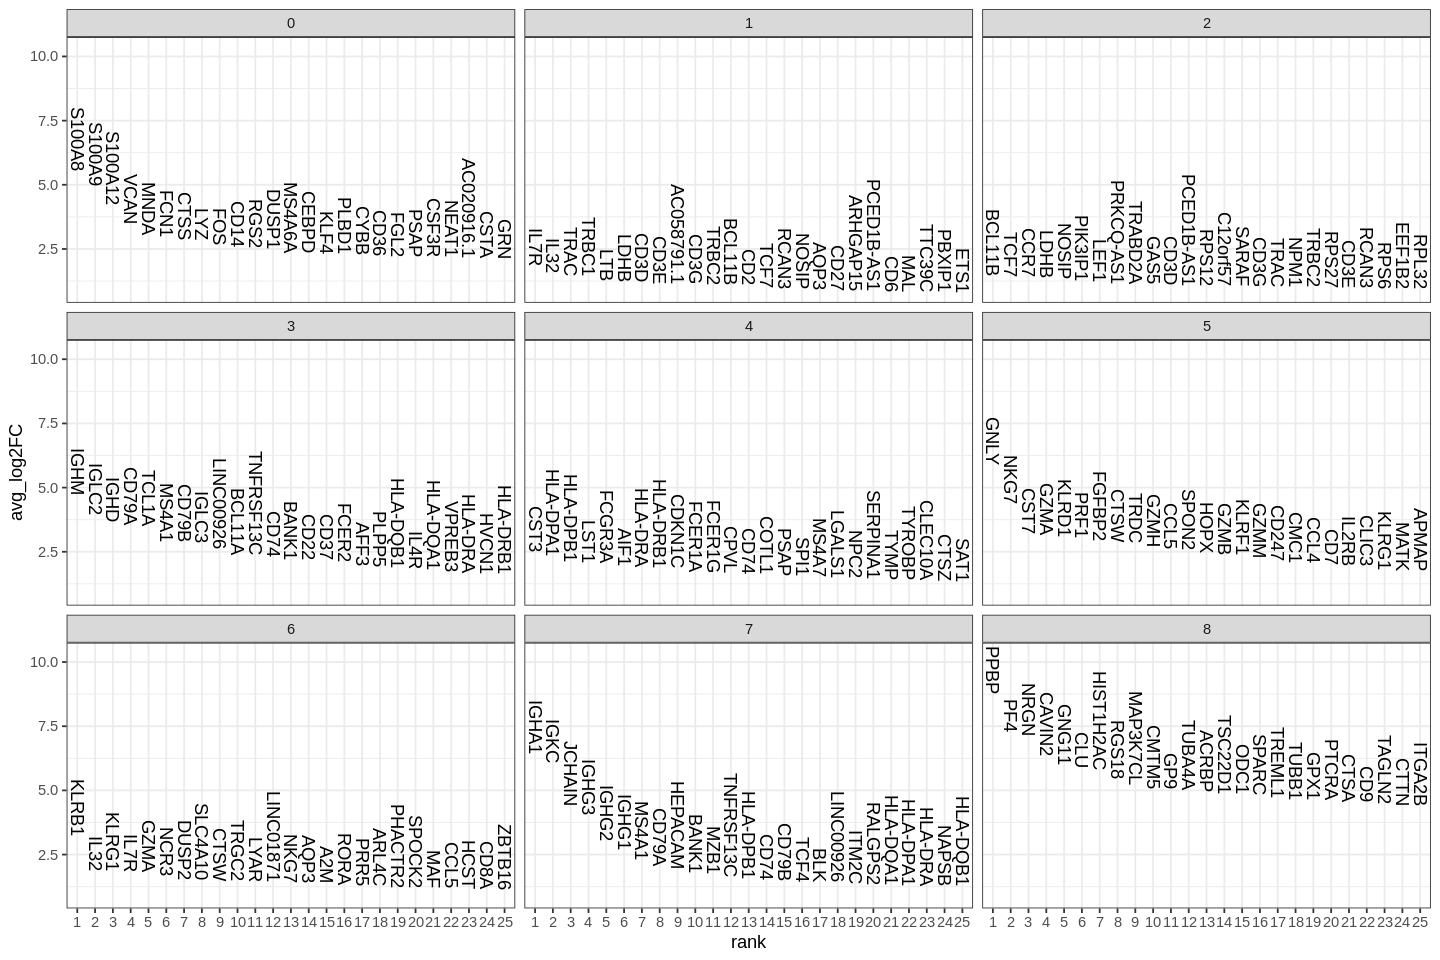

In [49]:
options(repr.plot.width=12, repr.plot.height=8)
plot_gene_rank(pbmc.markers, 25)

Student's t test is also supported

In [50]:
pbmc.markers.t <- FindAllMarkers(pbmc, test.use = "t", only.pos = TRUE, 
                               min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



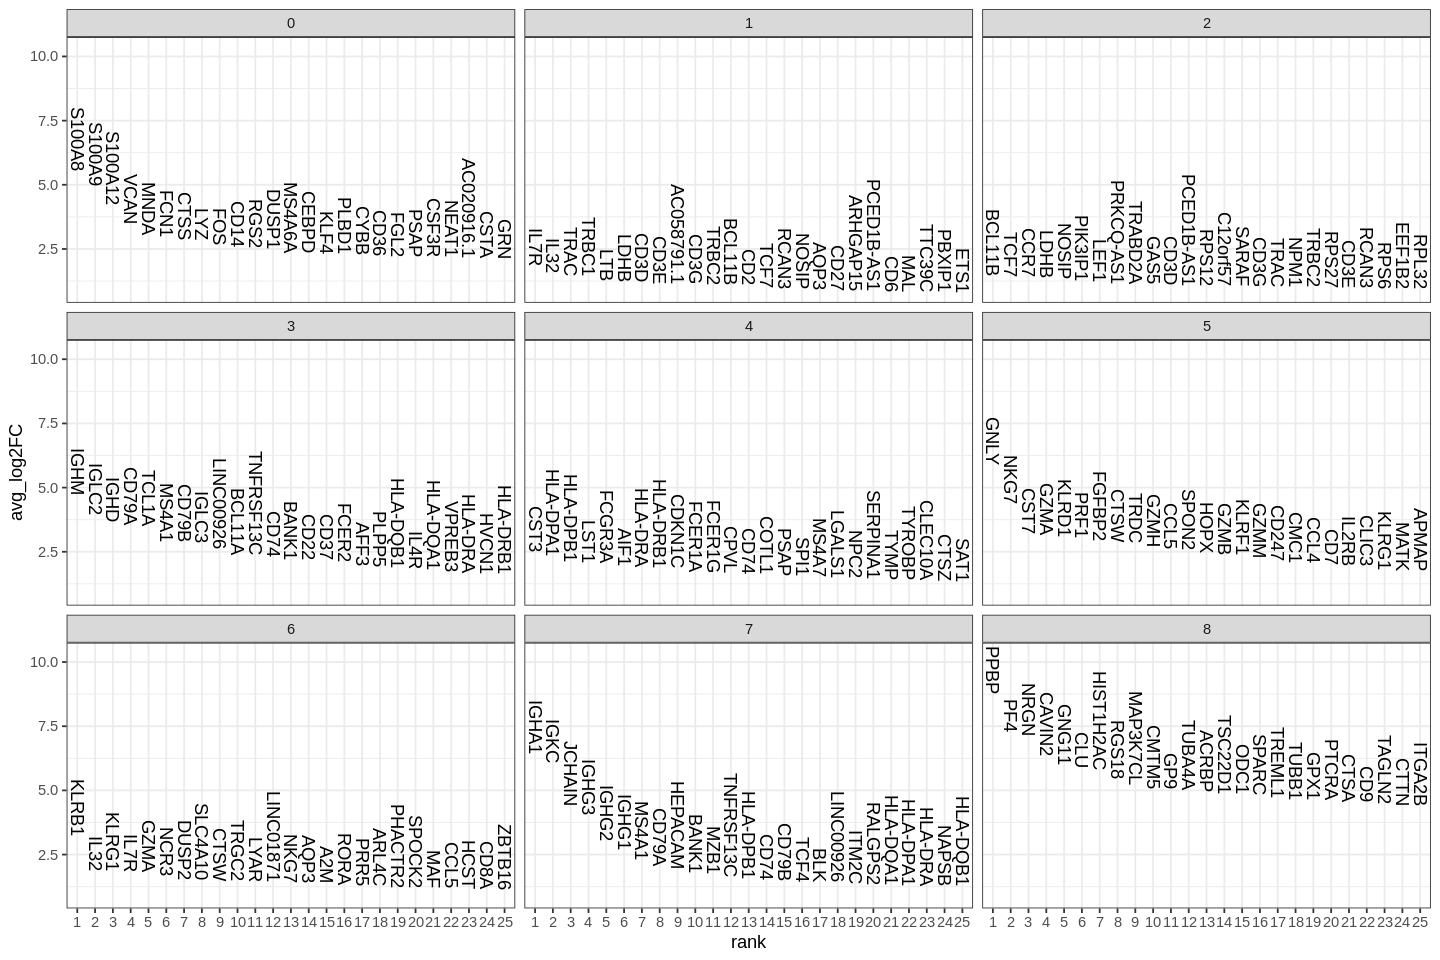

In [51]:
plot_gene_rank(pbmc.markers.t, 25)

Also logistic regression to test how good each gene is for deciding whether a cell is in a cluster.

In [52]:
pbmc.markers.lr <- FindAllMarkers(pbmc, test.use = "LR", only.pos = TRUE, 
                               min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Calculating cluster 8

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
W

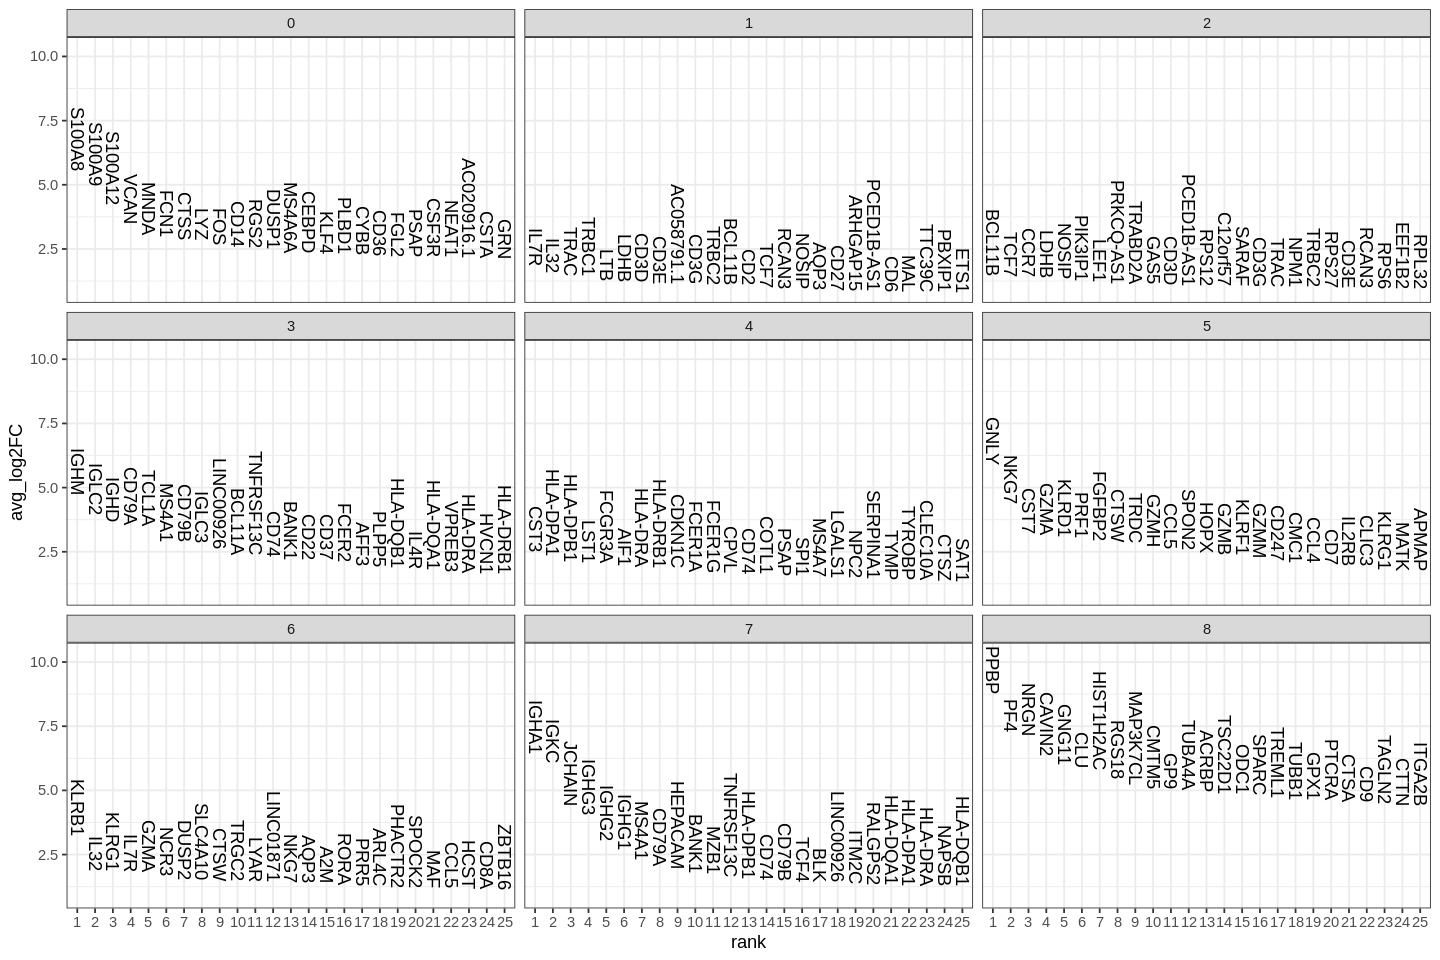

In [53]:
plot_gene_rank(pbmc.markers.lr, 25)

Seurat includes several tools for visualizing marker expression. VlnPlot (shows expression probability distributions across clusters), and FeaturePlot (visualizes feature expression on a tSNE or PCA plot) are our most commonly used visualizations. We also suggest exploring RidgePlot, CellScatter, and DotPlot as additional methods to view your dataset.



In [54]:
marker_genes <- sort(c('IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP', 'CCR7',
                'S100A4'))

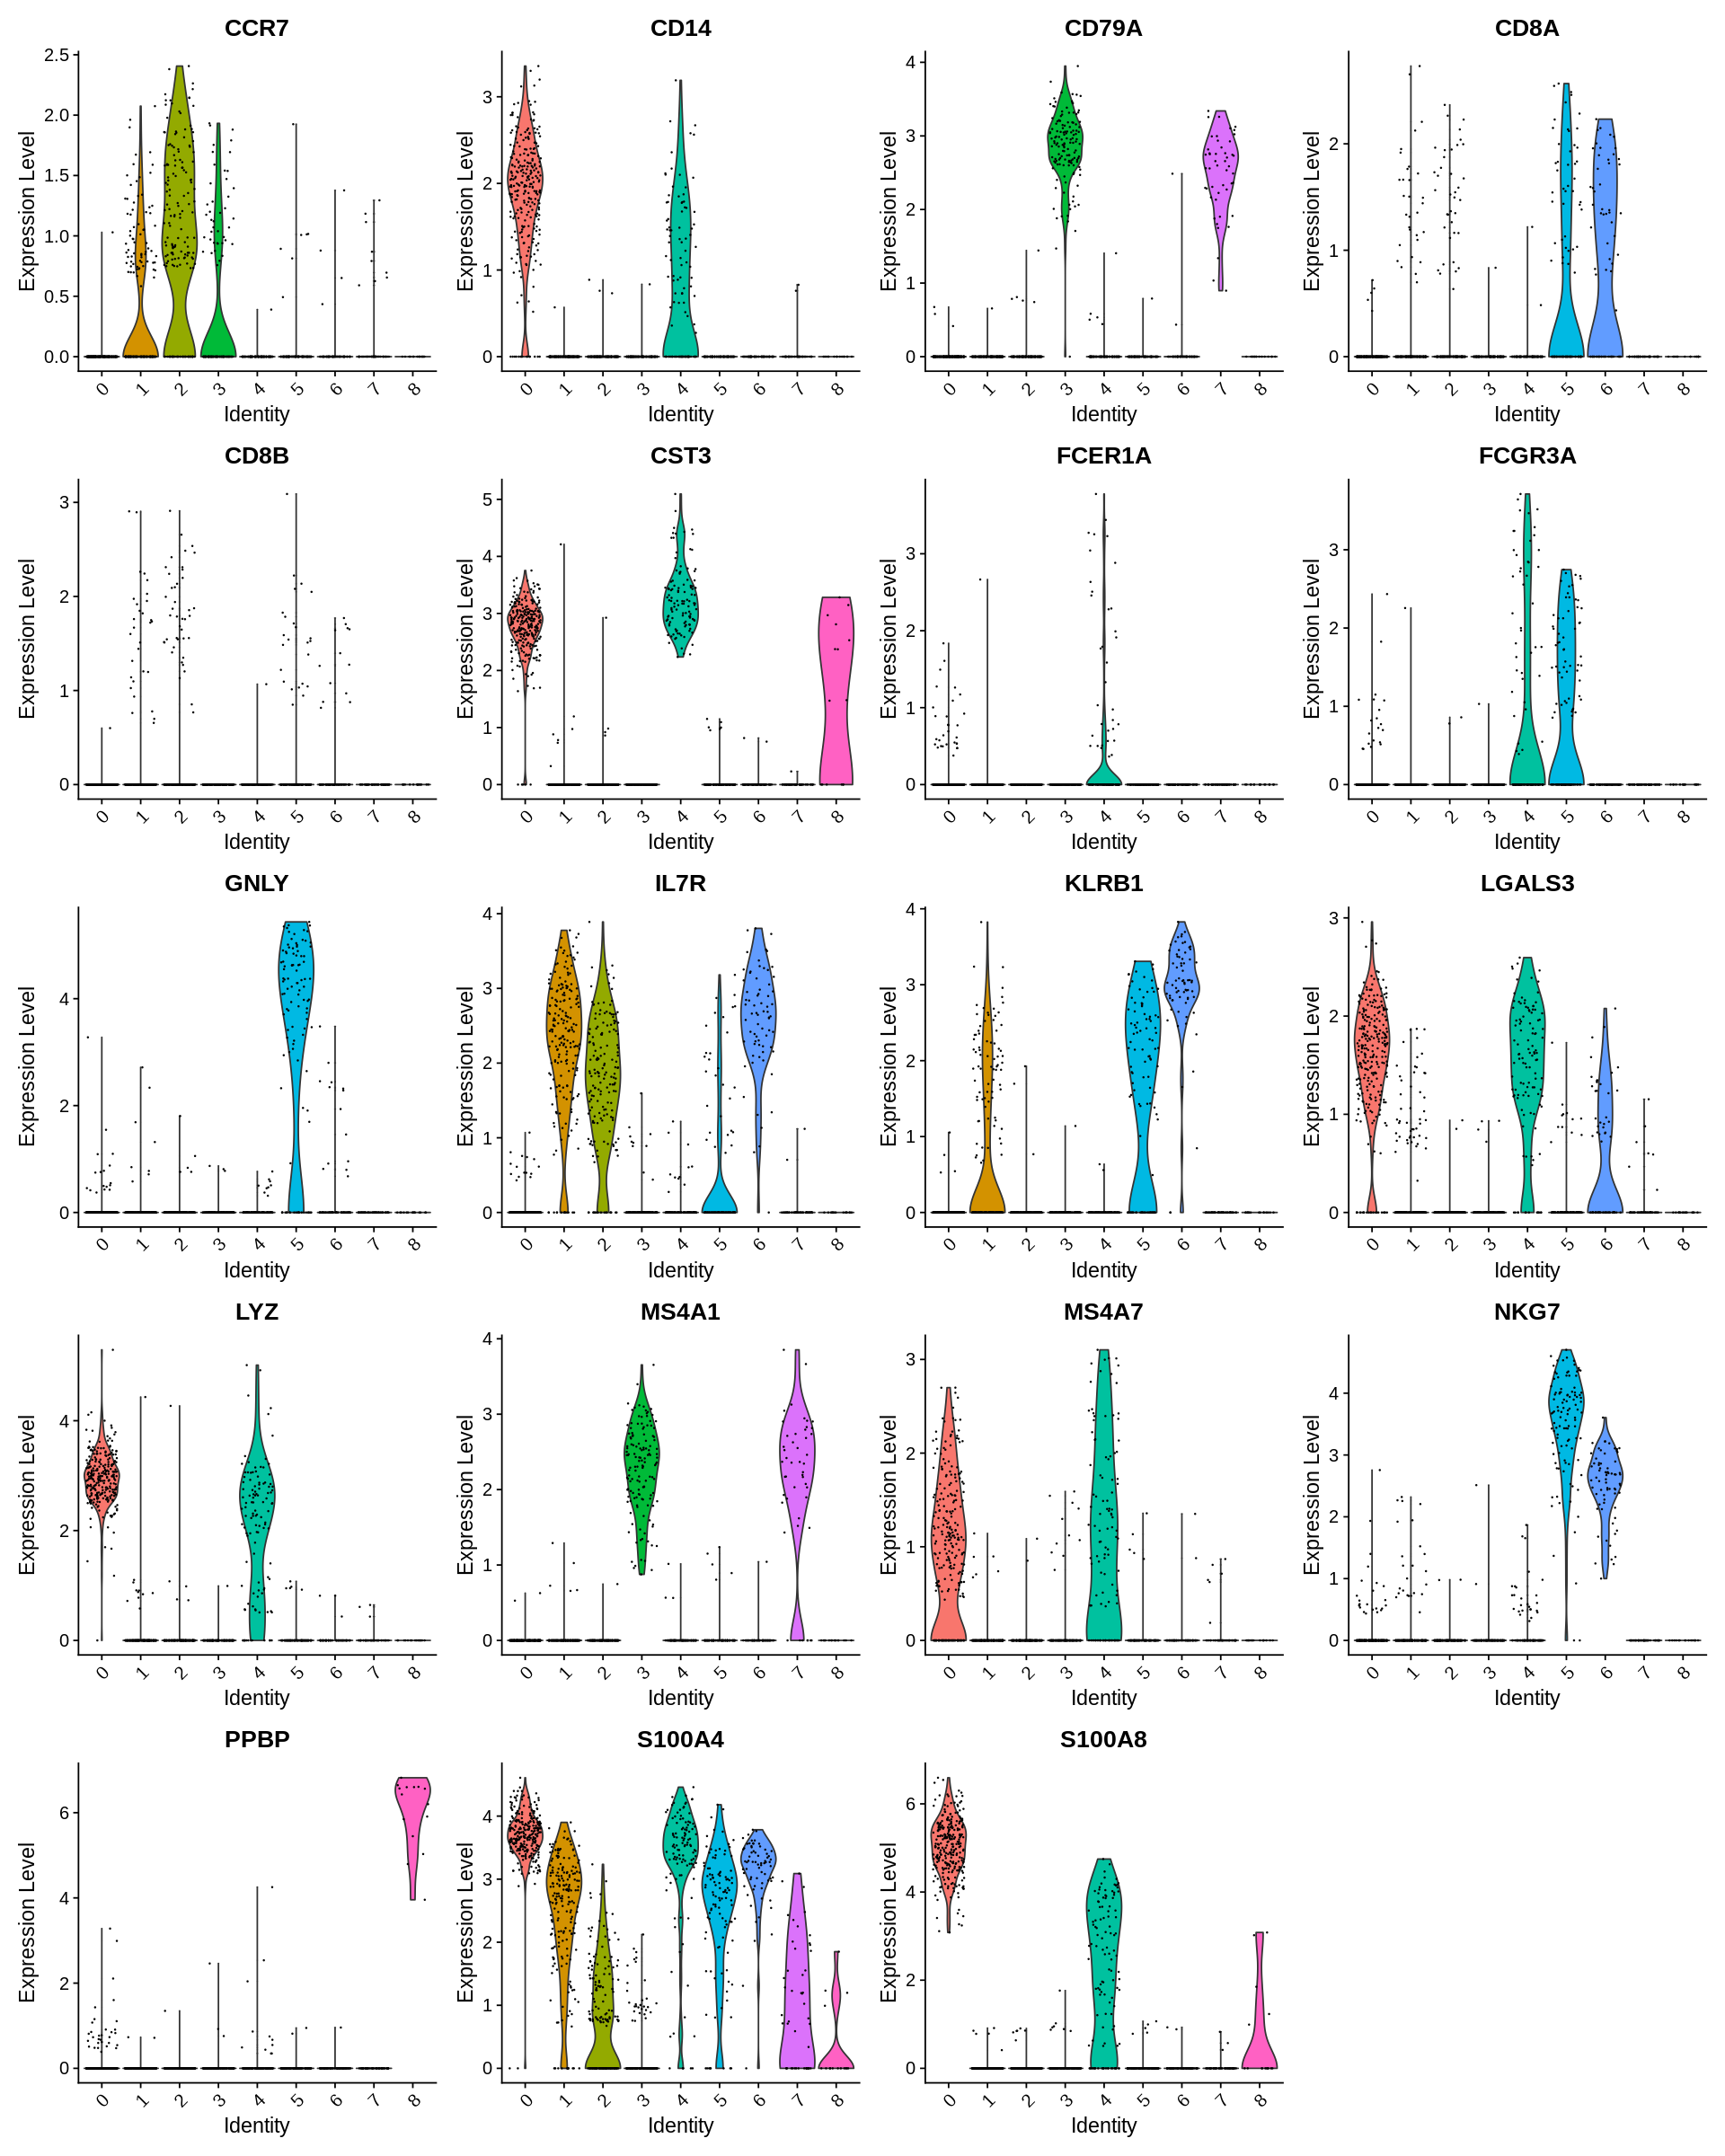

In [55]:
options(repr.plot.width=16, repr.plot.height=20)
VlnPlot(pbmc, features = marker_genes, ncol = 4)

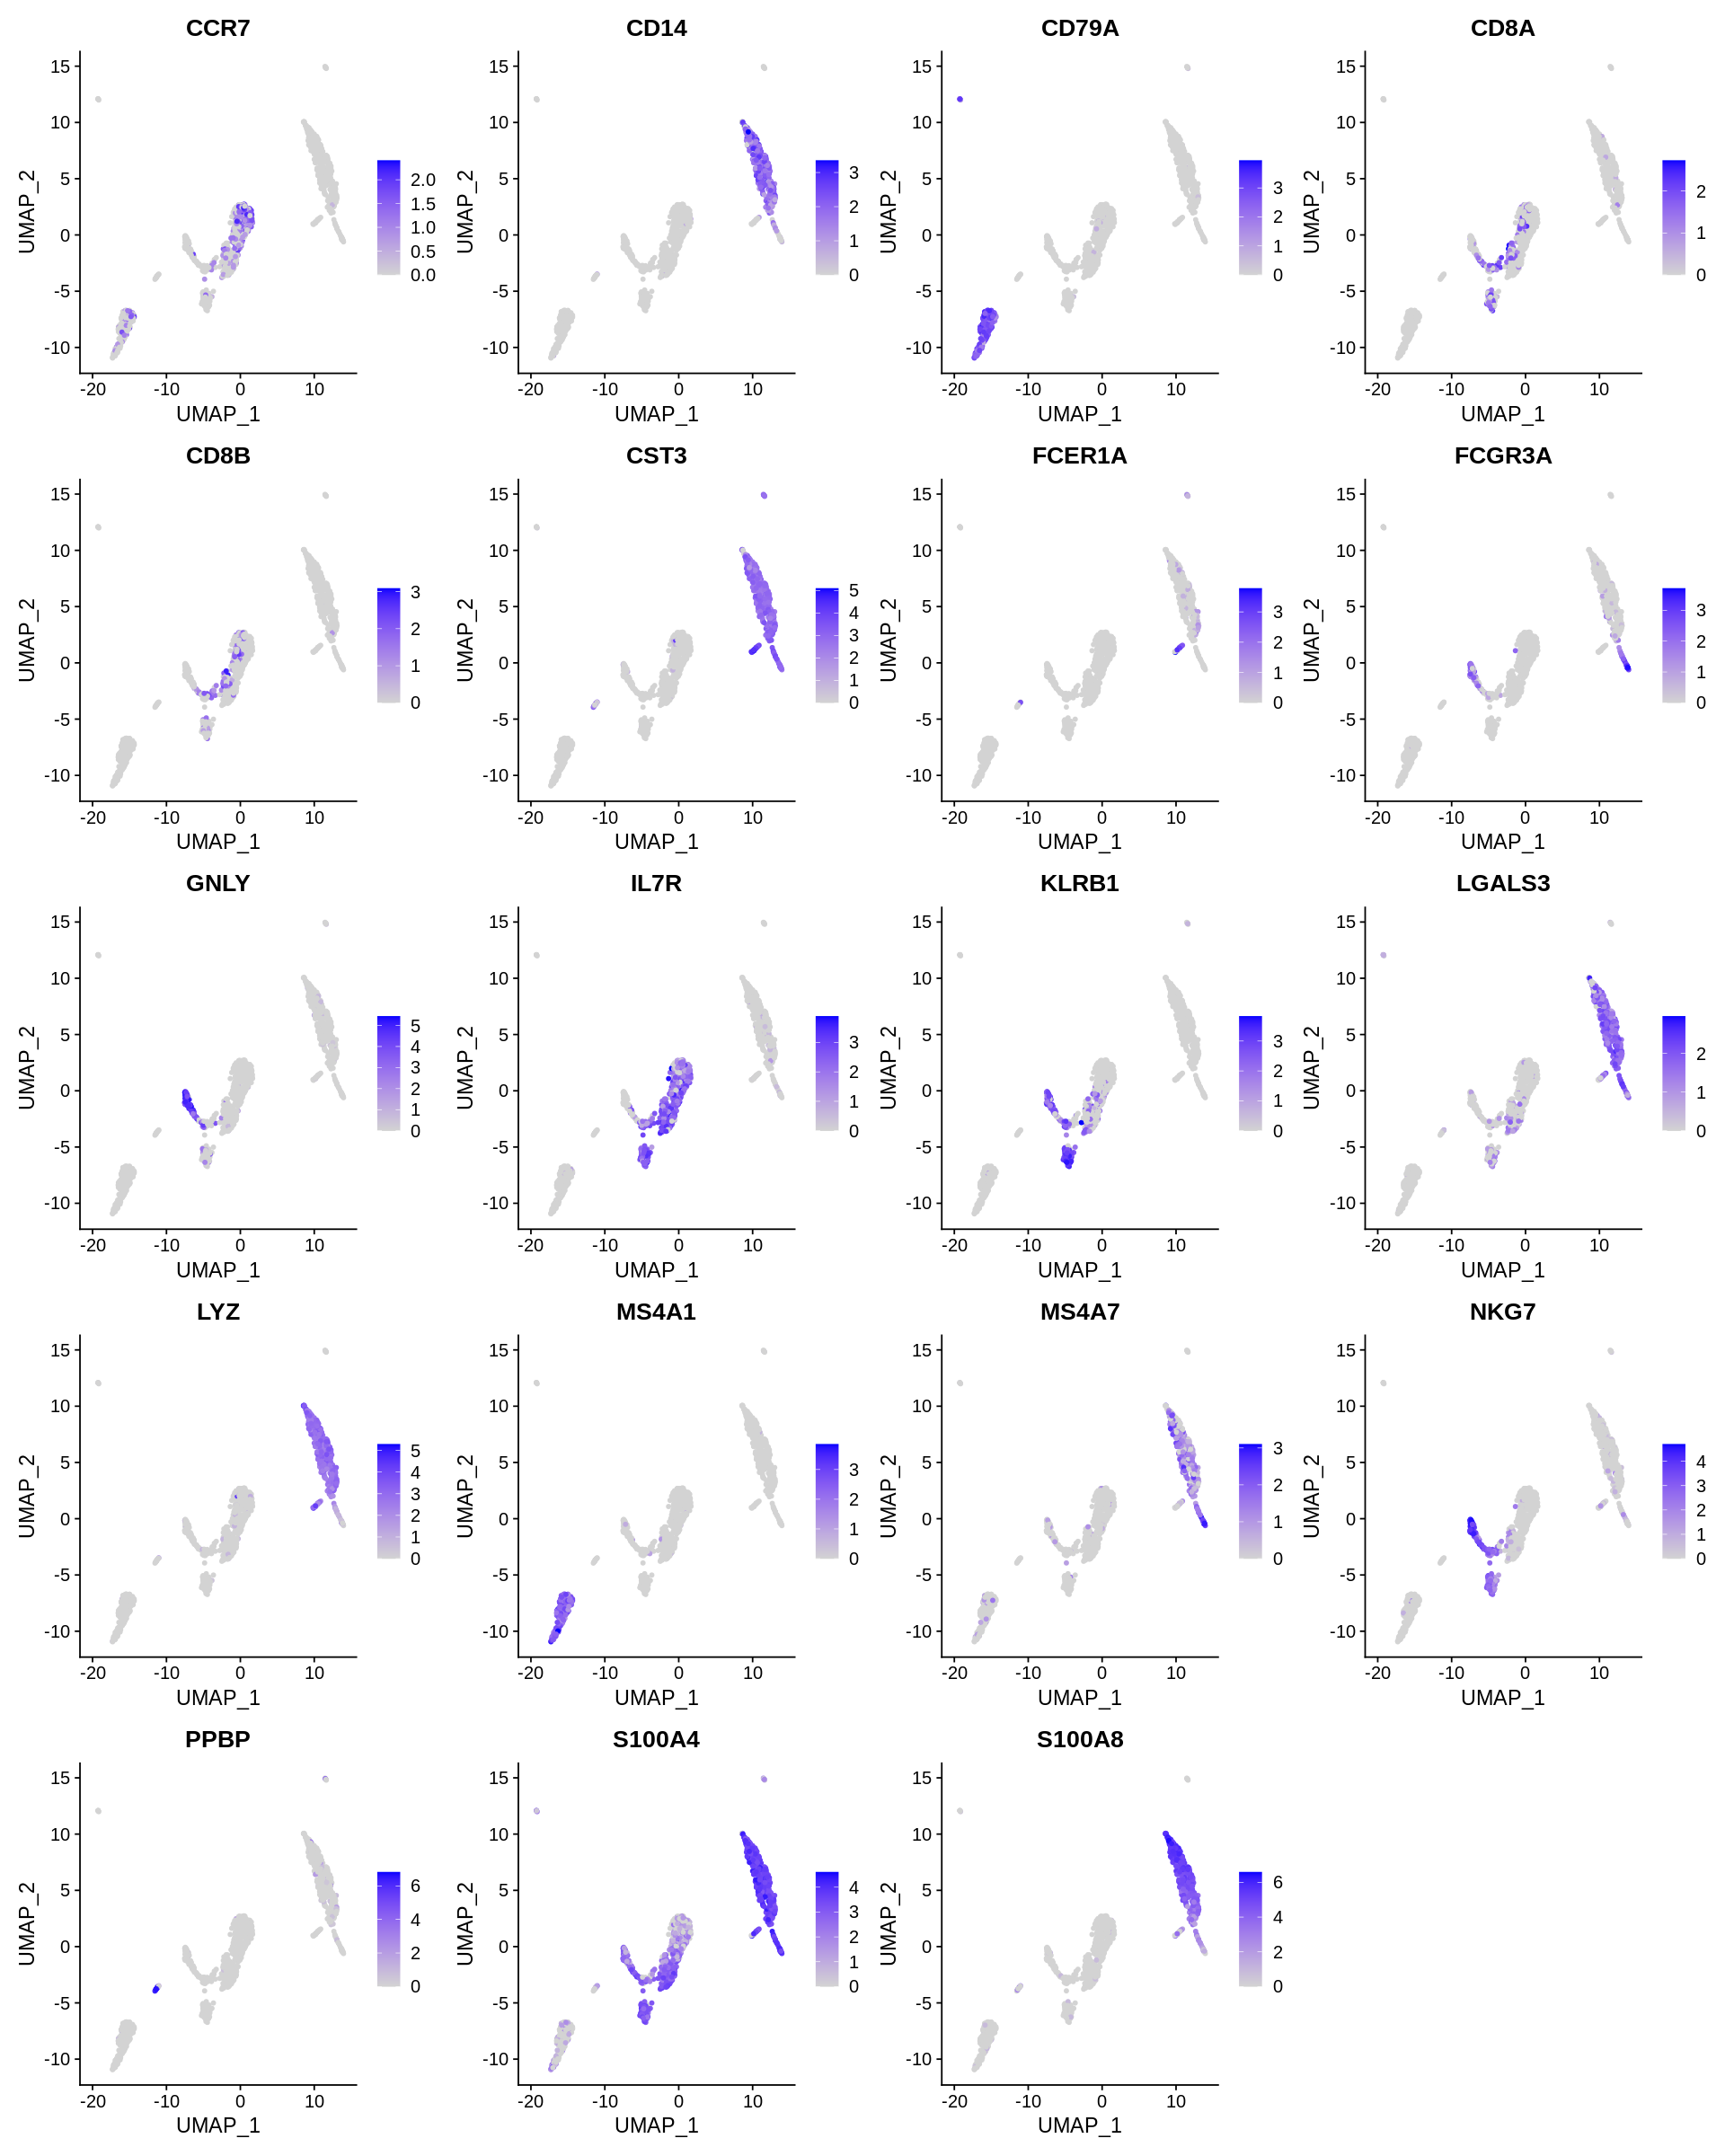

In [56]:
options(repr.plot.width=16, repr.plot.height=20)
FeaturePlot(pbmc, features = marker_genes, ncol = 4)

### Assigning cell type identity to clusters
In this dataset, we can use canonical markers to easily match the *de novo* clustering to known cell types:

Cluster ID | Markers | Cell Type
-----------|---------|-------------
0 |	CD14, LYZ |	CD14+ Mono
1	| IL7R, S100A4 |	Memory CD4+ T
2 |	IL7R, CCR7 |	Naive CD4+
3 |	MS4A1, CD79A |	B
4 |	FCGR3A, MS4A7 |	FCGR3A+ Mono
5 |	GNLY, NKG7 | NK
6 |	CD8A | CD8+ T
7 | MS4A1, CD79A | B
8 |	PPBP | Platelet

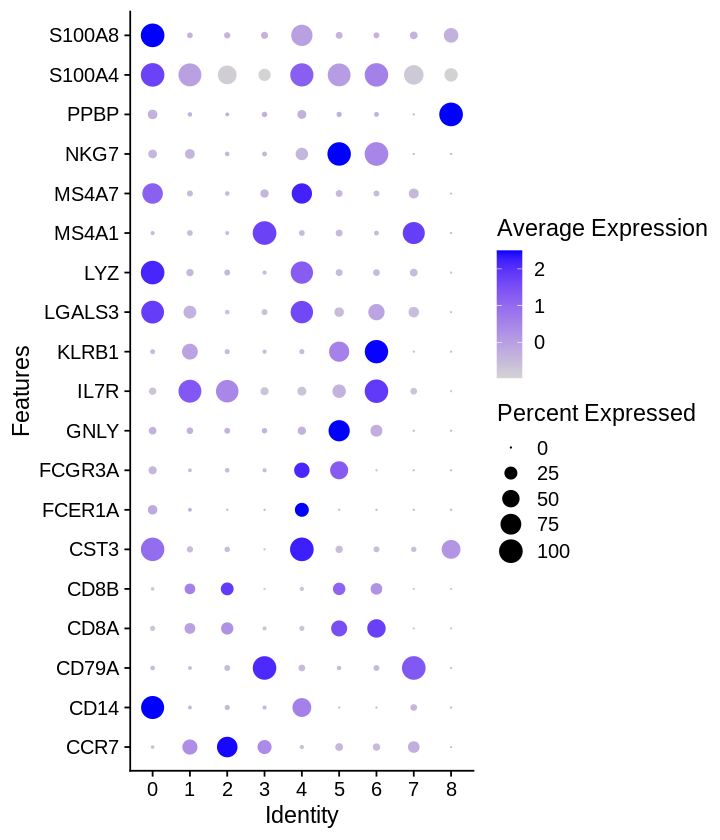

In [57]:
options(repr.plot.width=6, repr.plot.height=7)
DotPlot(pbmc, assay = "RNA", features = marker_genes, scale.by = "size") +
  coord_flip()

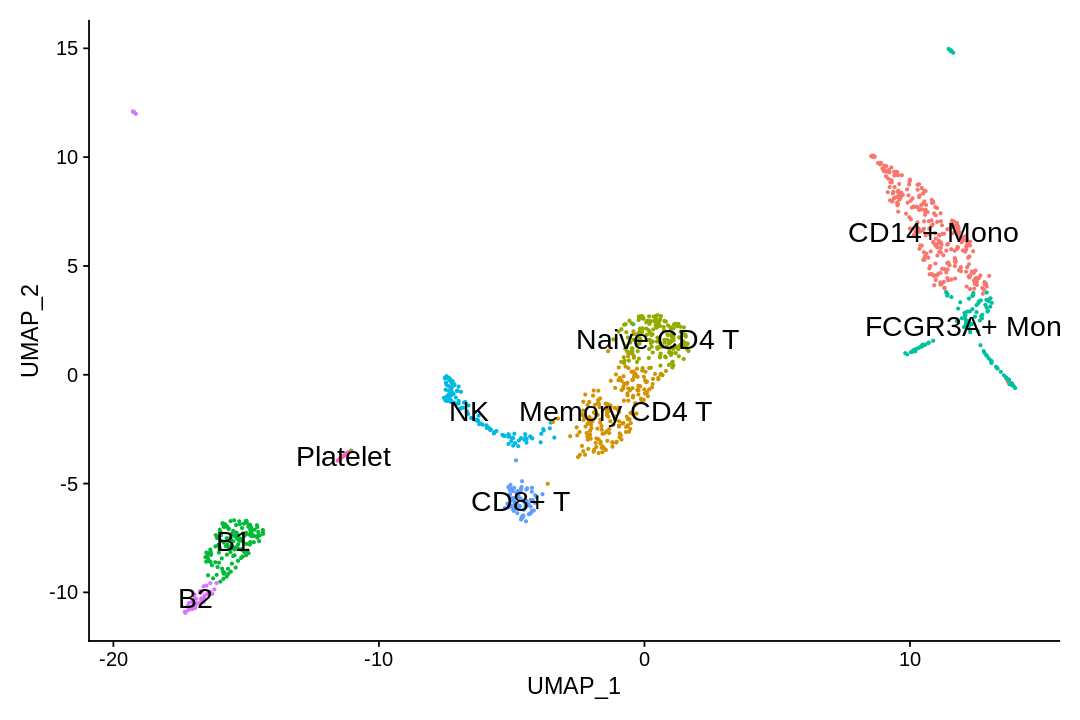

In [58]:
options(repr.plot.width=9, repr.plot.height=6)
new.cluster.ids <- c("CD14+ Mono", "Memory CD4 T", "Naive CD4 T", "B1", "FCGR3A+ Mono", 
    "NK", "CD8+ T", "B2", "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5, label.size = 6) + NoLegend()

In [59]:
Sys.time() - start_time

Time difference of 43.25291 mins

In [60]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] patchwork_1.1.1    forcats_0.5.1      stringr_1.4.0      dplyr_1.0.7       
 [5] purrr_0.3.4        readr_1.4.0        tidyr_1.1.3        tibble_3.1.2      
 [9] ggplot2_3.3.5      tidyverse_1.3.1    Matrix_1.3-4       SeuratObject_4.0.2
[13] Seurat_4.0.3      

lo

**Feedback**: please report any issues, or submit pull requests for improvements, in the [Github repository where this notebook is located](https://github.com/pachterlab/kallistobustools/blob/master/notebooks/kb_analysis_0_R.ipynb).